In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('train_data.tsv.gz', sep='\t')
df_test =  pd.read_csv('test_data.tsv.gz', sep='\t')

In [3]:
df_train.head()

,id,city,price,brand,model,drive_type,engine_summary,owner_type,generation,year,color,body,gear_type,wheel_type,state,is_new,doors_count,mileage,owners_by_pts
0,9cbd65bfd61bc7405d6866a5,Советск,40000.0,ВАЗ (Lada),2105,Задний,1.5 л / 71 л.с. / Бензиновый,Частники,1 поколение,1999,Фиолетовый,Седан,Механика,Левый,Хорошее,Нет,5.0,178000.0,3.0
1,5d6fa4d552284029123966a5,Москва,105000.0,ВАЗ (Lada),2114,Передний,1.5 л / 77 л.с. / Бензиновый,Частники,1 поколение,2006,Голубой,Хетчбэк,Механика,Левый,Хорошее,Нет,5.0,200000.0,2.0
2,52fd95e853654e3c4d7966a5,Александров,650000.0,Cadillac,SRX,Полный,3.6 л / 258 л.с. / Бензиновый,Частники,1 поколение,2008,Синий,Кроссовер,Автомат,Левый,Не битый,Нет,5.0,185000.0,3.0
3,beb7c749571bc740820038a5,Новокуйбышевск,400000.0,Chevrolet,Lacetti,Передний,1.6 л / 109 л.с. / Бензиновый,Частники,1 поколение,2013,Красный,Седан,Механика,Левый,Не битый,Нет,4.0,59000.0,1.0
4,34d7824a60964435b93c68a5,Москва,1000000.0,Jeep,Commander,Полный,3 л / 218 л.с. / Дизельный,Частники,1 поколение,2008,Черный,Внедорожник,Автомат,Левый,Не битый,Нет,5.0,200000.0,2.0


In [4]:
df_train.shape

(89959, 19)

(0, 10000000)

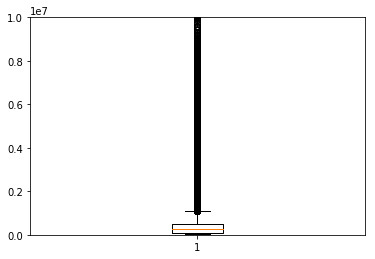

In [5]:
plt.boxplot(df_train.price)
plt.ylim(0,10**7)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f17c3146e10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f17c31505d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f17c3146890>],
 'medians': [<matplotlib.lines.Line2D at 0x7f17c3150cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f17c31556d0>],
 'means': []}

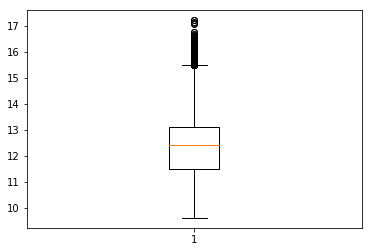

In [6]:
plt.boxplot(df_train.price.apply(np.log))
# maybe using log transformation of target is good idea

In [7]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, KFold

In [8]:
X_train = df_train.loc[:, ['mileage', 'brand']].values
y_train = df_train.loc[:, 'price'].values

X_test = df_test.loc[:, ['mileage', 'brand']].values

In [9]:
categ = [1] # categorical feauture index
categ_preprocess = \
Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))    
])
# firstly - impute missing values
# One hot encodding afterwards

numeric = [0] # numeric feauture index
numeric_preprocess = \
Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# firstly - impute missing values
# standart scaling afterwards

col_transformer = ColumnTransformer([
    ('categorical', categ_preprocess, categ),
    ('numeric', numeric_preprocess, numeric),
])
# combine transformations

In [10]:
model = \
Pipeline([
    ('preprocess', col_transformer),
    ('model', Ridge())
])
# pipeline with preprocessing and models

In [11]:
# setting parameter grid for hypersearch
param_grid = \
{'model__alpha': np.logspace(-3, 3, 100),
 'preprocess__numeric__impute__strategy': ['mean', 'median']}

# setting cv scheme
cv = KFold(n_splits=5, shuffle=True, random_state=123)

# setting hyperparameter search
searcher = \
RandomizedSearchCV(model, param_grid, n_iter=20, cv=cv, 
                   scoring='neg_mean_squared_error',
                   n_jobs=5, refit=True, verbose=2, 
                   random_state=123)

In [12]:
searcher.fit(X_train, np.log(y_train+1))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  4.1min finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               [1]),
                                                                              ('numeric',
                                                                               Pipeline(steps=[('impute',
      

In [13]:
best_model = searcher.best_estimator_

In [14]:
searcher.best_params_

{'preprocess__numeric__impute__strategy': 'median',
 'model__alpha': 0.012328467394420659}

In [15]:
y_hat = \
np.exp(best_model.predict(X_test))-1

In [16]:
submission = df_test.loc[:, ['id']]
submission.loc[:, 'price'] = y_hat

In [17]:
submission

,id,price
0,0342021095ab56065059d7a5,3.291404e+05
1,39ab2742629644350ccf79a5,3.393575e+05
2,3ec951329128402965155ba5,5.655789e+05
3,bc0847b8951bc74079b8bca5,1.010800e+05
4,258f0335b5654e3c500b3da5,3.662963e+05
5,ab6c52a2c3964435d6ce9da5,8.124676e+04
6,3a54d262211bc740123550b5,5.258435e+05
7,3fcd73d6c3284029c5d152b5,7.324347e+04
8,3aa0c6dcb9332b2f418f83b5,1.975076e+05
9,39bcf7eac01bc740ce3ed3b5,4.464985e+04


In [ ]:
submission.to_csv('baseline.csv', index=None)